# Import dependencies

In [1]:

import pandas as pd
import numpy as np
import os
import warnings
from pysolar.solar import *
import pytz
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt

if os.getcwd() != '/Users/matildemaccio/Projects/Python/Renovus/solarec-python/app':
    os.chdir('../../..')

from ml.model import Model
from ml.model import load_model

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', True)

# Load Data

In [2]:
GEN_DATA_PATH = os.path.join('ml', 'data', '1_pre_processed_data.parquet')
df = pd.read_parquet(GEN_DATA_PATH)

In [3]:
display(df.head())

,Temperature,Precipitation Total,Relative Humidity,Wind Speed,Wind Direction,Cloud Cover Total,Cloud Cover High,Cloud Cover Medium,Cloud Cover Low,CAPE,Sunshine Duration,Shortwave Radiation,Longwave Radiation,UV Radiation,Direct Shortwave Radiation,Diffuse Shortwave Radiation,Mean Sea Level Pressure,Generated Power,Device Temp.,Voltage
index,,,,,,,,,,,,,,,,,,,,
2019-10-01 00:00:00,16.00,2.00,97.00,8.00,137.00,23.00,77.00,22.00,14.00,"1,310.00",0.00,0.00,401.00,0.00,0.00,0.00,"1,003.00",0.00,0.00,0.00
2019-10-01 01:00:00,16.00,1.00,99.00,11.00,169.00,34.00,40.00,34.00,22.00,776.00,0.00,0.00,389.00,0.00,0.00,0.00,"1,003.00",0.00,0.00,0.00
2019-10-01 02:00:00,15.00,2.00,99.00,17.00,166.00,48.00,69.00,38.00,48.00,817.00,0.00,0.00,371.00,0.00,0.00,0.00,"1,003.00",0.00,0.00,0.00
2019-10-01 03:00:00,15.00,3.00,99.00,18.00,153.00,100.00,98.00,100.00,78.00,"1,017.00",0.00,0.00,378.00,0.00,0.00,0.00,"1,002.00",0.00,0.00,0.00
2019-10-01 04:00:00,15.00,3.00,99.00,17.00,143.00,100.00,100.00,100.00,100.00,791.00,0.00,0.00,391.00,0.00,0.00,0.00,"1,002.00",0.00,0.00,0.00


# Keep existing features

In [4]:
features_to_keep = [
    'Temperature',
    'Precipitation Total',
    'Cloud Cover Total',
    'Shortwave Radiation',
    'Generated Power'
]
# remove irrelevant features
df = df[features_to_keep]


In [5]:
display(df.head())
display(df.describe())

,Temperature,Precipitation Total,Cloud Cover Total,Shortwave Radiation,Generated Power
index,,,,,
2019-10-01 00:00:00,16.00,2.00,23.00,0.00,0.00
2019-10-01 01:00:00,16.00,1.00,34.00,0.00,0.00
2019-10-01 02:00:00,15.00,2.00,48.00,0.00,0.00
2019-10-01 03:00:00,15.00,3.00,100.00,0.00,0.00
2019-10-01 04:00:00,15.00,3.00,100.00,0.00,0.00


,Temperature,Precipitation Total,Cloud Cover Total,Shortwave Radiation,Generated Power
count,"27,193.00","27,193.00","27,193.00","27,193.00","27,193.00"
mean,16.63,0.09,34.12,198.76,"9,167.52"
std,5.75,0.52,34.72,283.64,"13,770.64"
min,1.00,0.00,0.00,0.00,0.00
25%,12.00,0.00,1.00,0.00,0.00
50%,17.00,0.00,26.00,10.00,137.42
75%,21.00,0.00,60.00,361.00,"16,216.45"
max,39.00,11.00,100.00,"1,110.00","50,001.47"


# Add calculated features

### Temporal Feature Engineering

In [6]:
TARGET_COLUMN = 'Generated Power'

df['hour'] = df.index.hour
df['month'] = df.index.month
df['day'] = df.index.day

df['season'] = df['month'].apply(lambda x: 0 if x in [12, 1, 2] else (1 if x in [3, 4, 5] else (2 if x in [6, 7, 8] else 3)))

In [7]:
display(df[['hour', 'month', 'day', 'season']].head(12))

,hour,month,day,season
index,,,,
2019-10-01 00:00:00,0,10,1,3
2019-10-01 01:00:00,1,10,1,3
2019-10-01 02:00:00,2,10,1,3
2019-10-01 03:00:00,3,10,1,3
2019-10-01 04:00:00,4,10,1,3
2019-10-01 05:00:00,5,10,1,3
2019-10-01 06:00:00,6,10,1,3
2019-10-01 07:00:00,7,10,1,3
2019-10-01 08:00:00,8,10,1,3


### Use one hot encoding for representing season, month and hour data

In [8]:
df = pd.concat([df, pd.get_dummies(df['season'], prefix='season')], axis=1)
df = pd.concat([df, pd.get_dummies(df['month'], prefix='month')], axis=1)
df = pd.concat([df, pd.get_dummies(df['hour'], prefix='hour')], axis=1)
df.drop(['season', 'month', 'hour'], axis=1, inplace=True)

In [9]:
display(df[['season_0', 'season_1', 'season_2', 'season_3', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_12', 'hour_23']].describe())

,season_0,season_1,season_2,season_3,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_12,hour_23
count,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,20689,20569,20569,19752,24961,25153,24961,25033,24961,25033,24961,24961,25033,24217,24888,24961,26059,26060,26060


### Lag-based feature generation

In [10]:
df[f'{TARGET_COLUMN} {1} Hour Lag'] = df[TARGET_COLUMN].shift(1)

In [11]:
display(df.columns)

Index(['Temperature', 'Precipitation Total', 'Cloud Cover Total', 'Shortwave Radiation', 'Generated Power', 'day', 'season_0', 'season_1', 'season_2', 'season_3', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'Generated Power 1 Hour Lag'], dtype='object')

### Additional Contextual Features

In [12]:
df['Hours Since Last Rain'] = 0
last_rain_date = None

for index, row in df.iterrows():
    if row['Precipitation Total'] > 0:
        df.at[index, 'Hours Since Last Rain'] = 0
        last_rain_date = index
    else:
        if last_rain_date is None:
            df.at[index, 'Hours Since Last Rain'] = 0
        else:
            df.at[index, 'Hours Since Last Rain'] = (index - last_rain_date).total_seconds() / 3600

### Solar Zenith Angle

In [13]:
LATITUDE = -34.68
LONGITUDE = -55.82
tz = pytz.timezone('America/Montevideo')

def get_solar_zenith_angle(row):
    time = tz.localize(row.name)
    sza = get_altitude(LATITUDE, LONGITUDE, time)
    return sza

df['Solar Zenith Angle'] = df.apply(lambda row: get_solar_zenith_angle(row), axis=1)

In [14]:
display(df[['Precipitation Total', 'Hours Since Last Rain', 'Solar Zenith Angle']])

,Precipitation Total,Hours Since Last Rain,Solar Zenith Angle
index,,,
2019-10-01 00:00:00,2.00,0,-51.49
2019-10-01 01:00:00,1.00,0,-51.74
2019-10-01 02:00:00,2.00,0,-47.08
2019-10-01 03:00:00,3.00,0,-38.86
2019-10-01 04:00:00,3.00,0,-28.54
...,...,...,...
2022-11-06 20:00:00,0.00,172,-8.83
2022-11-06 21:00:00,0.00,173,-19.30
2022-11-06 22:00:00,0.00,174,-28.30


In [15]:
print([x for x in df.columns])

['Temperature', 'Precipitation Total', 'Cloud Cover Total', 'Shortwave Radiation', 'Generated Power', 'day', 'season_0', 'season_1', 'season_2', 'season_3', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'Generated Power 1 Hour Lag', 'Hours Since Last Rain', 'Solar Zenith Angle']


### Identifying and Handling Outliers

In [16]:
RADIATION_THRESHOLD = 100
df_radiation_but_no_power = df[(df['Generated Power'] == 0) & (df['Shortwave Radiation'] > RADIATION_THRESHOLD)]

display('Number of rows with radiation but no power: {}'.format(len(df_radiation_but_no_power)))

'Number of rows with radiation but no power: 253'

### Statistical outliers detection

In [17]:
Q1 = df['Generated Power'].quantile(0.25)
Q3 = df['Generated Power'].quantile(0.75)
IQR = Q3 - Q1

multiplier = 1.5

outliers = df[(df['Generated Power'] < (Q1 - multiplier * IQR)) | (df['Generated Power'] > (Q3 + multiplier * IQR))]

display('Number of outliers: {}'.format(len(outliers)))

'Number of outliers: 1210'

In [18]:
df = df.drop(outliers.index)
df = df.drop(df_radiation_but_no_power.index)

In [19]:
print([x for x in df.columns])

['Temperature', 'Precipitation Total', 'Cloud Cover Total', 'Shortwave Radiation', 'Generated Power', 'day', 'season_0', 'season_1', 'season_2', 'season_3', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'Generated Power 1 Hour Lag', 'Hours Since Last Rain', 'Solar Zenith Angle']


### Save dataset to use it in the next steps of the pipeline

In [20]:
df.to_parquet(os.path.join('ml', 'data', '5_training_production_model_data.parquet'))

In [21]:
print([x for x in df.columns])

['Temperature', 'Precipitation Total', 'Cloud Cover Total', 'Shortwave Radiation', 'Generated Power', 'day', 'season_0', 'season_1', 'season_2', 'season_3', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'Generated Power 1 Hour Lag', 'Hours Since Last Rain', 'Solar Zenith Angle']


# Model Training

### Split data

In [22]:
train, validate, test = np.split(df, [int(.6*len(df)), int(.8*len(df))])

x_train = train.drop(columns=[TARGET_COLUMN])
x_val = validate.drop(columns=[TARGET_COLUMN])
x_test = test.drop(columns=[TARGET_COLUMN])

y_train = train[TARGET_COLUMN]
y_val = validate[TARGET_COLUMN]
y_test = test[TARGET_COLUMN]

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

print('Train: ', len(train))
print('Validate: ', len(validate))
print('Test: ', len(test))

Train:  15438
Validate:  5146
Test:  5146


### Save scalars

In [23]:
# save x_scaler and y_scaler
import joblib

joblib.dump(x_scaler, os.path.join('ml', 'models', 'x_scaler.pkl'))
joblib.dump(y_scaler, os.path.join('ml', 'models', 'y_scaler.pkl'))

['ml/models/y_scaler.pkl']

### Training

In [24]:
results = pd.DataFrame()
def calculate_metrics(y_pred, y_val, model_name, hyperparams):
    """
    Calculate metrics for the model
    """
    global results
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    print(f'Model: {model_name}')
    print(f'Hyperparameters: {hyperparams}')
    # print(f'MSE: {mse}')
    # print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    #print('\n')    

    df = pd.DataFrame({
        'model': [model_name],        
        'mae': [mae],
        'mse': [mse],
        'mae': [mae],
        'hyperparams': [hyperparams]
    })
    results = pd.concat([results, df])   

    return mse, rmse, mae

In [25]:

# train cat_boost model
from catboost import CatBoostRegressor

cat_boost_model = CatBoostRegressor(verbose=1, 
                          bagging_temperature= 0.153, 
                          border_count=218, 
                          depth=7,
                          iterations=400, 
                          l2_leaf_reg=4.030, 
                          learning_rate=0.182,
                          random_strength=0.761,
                          rsm=0.838,
                          subsample=0.793)

cat_boost_model.fit(x_train_scaled, y_train_scaled, eval_set=(x_val_scaled, y_val_scaled))

y_pred = cat_boost_model.predict(x_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))

calculate_metrics(y_pred, y_test, 'CatBoost', cat_boost_model.get_params())

0:	learn: 0.8452617	test: 0.8756589	best: 0.8756589 (0)	total: 58.8ms	remaining: 23.5s
1:	learn: 0.7148432	test: 0.7399447	best: 0.7399447 (1)	total: 60.8ms	remaining: 12.1s
2:	learn: 0.6155905	test: 0.6327888	best: 0.6327888 (2)	total: 63.3ms	remaining: 8.38s
3:	learn: 0.5361891	test: 0.5487388	best: 0.5487388 (3)	total: 65.3ms	remaining: 6.47s
4:	learn: 0.4745641	test: 0.4863315	best: 0.4863315 (4)	total: 67.2ms	remaining: 5.31s
5:	learn: 0.4236996	test: 0.4334565	best: 0.4334565 (5)	total: 69.4ms	remaining: 4.56s
6:	learn: 0.3810331	test: 0.3904166	best: 0.3904166 (6)	total: 71.1ms	remaining: 3.99s
7:	learn: 0.3512810	test: 0.3608675	best: 0.3608675 (7)	total: 72.7ms	remaining: 3.56s
8:	learn: 0.3268638	test: 0.3356894	best: 0.3356894 (8)	total: 75.3ms	remaining: 3.27s
9:	learn: 0.3095956	test: 0.3202404	best: 0.3202404 (9)	total: 76.9ms	remaining: 3s
10:	learn: 0.2948545	test: 0.3058606	best: 0.3058606 (10)	total: 78.7ms	remaining: 2.78s
11:	learn: 0.2836978	test: 0.2954130	best: 0

(7978013.848362655, 2824.537811459187, 1408.4814853568487)

# Save model

In [26]:
model = Model(cat_boost_model, x_train.columns, x_scaler, y_scaler, trained_capacity=50)
model.save(os.path.join('ml', 'models', 'cat_boost_model.pkl'))

# Load model

In [27]:
model = load_model(os.path.join('ml', 'models', 'cat_boost_model.pkl'), 50)

# Predict to verify

In [28]:
y_pred = model.predict(x_test)
y_pred = y_pred * 1000

calculate_metrics(y_pred, y_test, 'CatBoost', model.cat_boost_model.get_params())

Model: CatBoost
Hyperparameters: {'iterations': 400, 'learning_rate': 0.182, 'depth': 7, 'l2_leaf_reg': 4.03, 'rsm': 0.838, 'loss_function': 'RMSE', 'border_count': 218, 'verbose': 1, 'random_strength': 0.761, 'bagging_temperature': 0.153, 'subsample': 0.793}
MAE: 1399.3012595543464


(7976571.0026701195, 2824.282387203893, 1399.3012595543464)

                              Prediction
index                                   
2022-04-05 05:00:00                69.00
2022-04-05 06:00:00                63.00
2022-04-05 07:00:00                63.00
2022-04-05 08:00:00             5,094.00
2022-04-05 09:00:00            22,245.00
...                                  ...
2022-11-06 20:00:00                 0.00
2022-11-06 21:00:00                 0.00
2022-11-06 22:00:00                 0.00
2022-11-06 23:00:00                 9.00
2022-11-07 00:00:00                 0.00

[5146 rows x 1 columns]


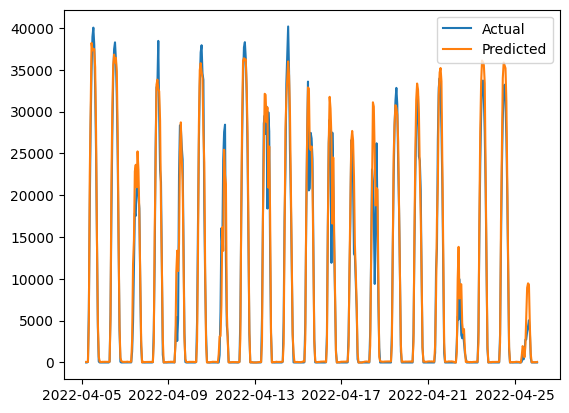

                             Temperature  Precipitation Total    Cloud Cover Total  Shortwave Radiation      Generated Power  day  season_0  season_1  season_2  season_3  month_1  month_2  month_3  month_4  month_5  month_6  month_7  month_8  month_9  month_10  month_11  month_12  hour_0  hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  Generated Power 1 Hour Lag  Hours Since Last Rain   Solar Zenith Angle
index                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [29]:
print(y_pred)

# graph predictions and actual values
plt.plot(y_test.index[:500], y_test[:500], label='Actual')
plt.plot(y_test.index[:500], y_pred[:500], label='Predicted')
plt.legend()
plt.show()

print(df.head())